In [23]:
%pip install -r requirements.txt

You should consider upgrading via the '/home/taffarel55/Repositórios/tcc/5. Modelo tflite com venv/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
from tensorflow.keras import layers

In [25]:
# Print versions
!python --version
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Matplotlib ' + matplotlib.__version__)

Python 3.9.0
Numpy 1.24.3
TensorFlow 2.12.0
Matplotlib 3.7.1


In [26]:
# Settings
nsamples = 1000     # Number of samples to use as a dataset
val_ratio = 0.2     # Percentage of samples that should be held for validation set
test_ratio = 0.2    # Percentage of samples that should be held for test set
tflite_model_name = 'sine_model'  # Will be given .tflite suffix
c_model_name = 'sine_model'       # Will be given .h suffix

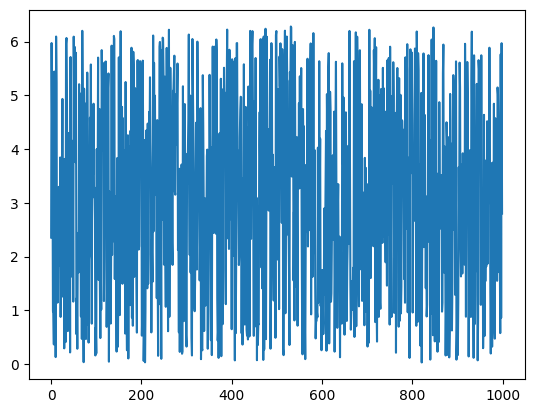

In [27]:
# Generate some random samples
np.random.seed(42)
x_values = np.random.uniform(low=0, high=(2 * math.pi), size=nsamples)
plt.plot(x_values)

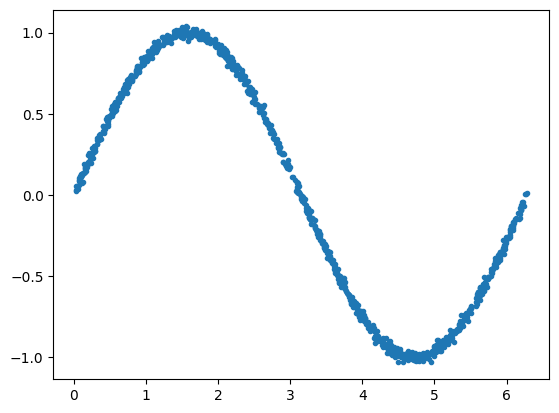

In [28]:
# Create a noisy sinewave with these values
y_values = np.sin(x_values) + (0.02 * np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')
     

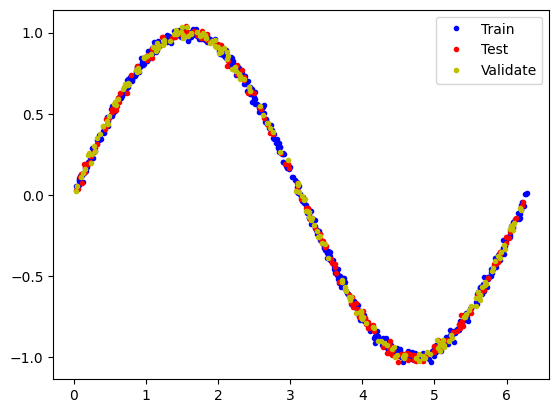

In [29]:
# Plit the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

In [30]:
# Create a model
model = tf.keras.Sequential()
model.add(layers.Dense(24, activation='softmax', input_shape=(1,)))
model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dense(1))

In [31]:
# View model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 24)                48        
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

In [33]:
# Train model
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Epoch 1/500
6/6 [==============================] - 1s 32ms/step - loss: 0.6085 - mae: 0.6085 - val_loss: 0.6305 - val_mae: 0.6305
Epoch 2/500
6/6 [==============================] - 0s 7ms/step - loss: 0.5990 - mae: 0.5990 - val_loss: 0.6224 - val_mae: 0.6224
Epoch 3/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5914 - mae: 0.5914 - val_loss: 0.6152 - val_mae: 0.6152
Epoch 4/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5847 - mae: 0.5847 - val_loss: 0.6078 - val_mae: 0.6078
Epoch 5/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5779 - mae: 0.5779 - val_loss: 0.6005 - val_mae: 0.6005
Epoch 6/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5711 - mae: 0.5711 - val_loss: 0.5931 - val_mae: 0.5931
Epoch 7/500
6/6 [==============================] - 0s 7ms/step - loss: 0.5640 - mae: 0.5640 - val_loss: 0.5854 - val_mae: 0.5854
Epoch 8/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5569 - mae: 0.5569 - va

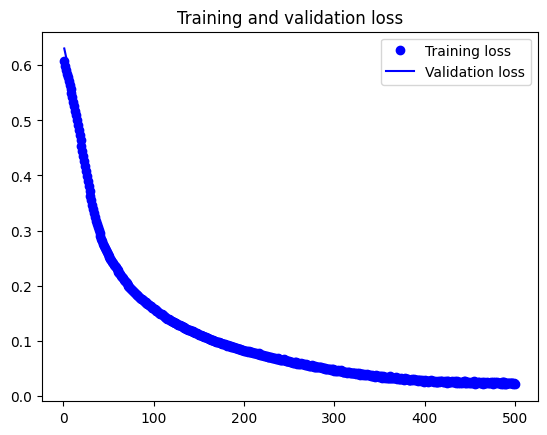

In [34]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

7/7 [==============================] - 0s 2ms/step


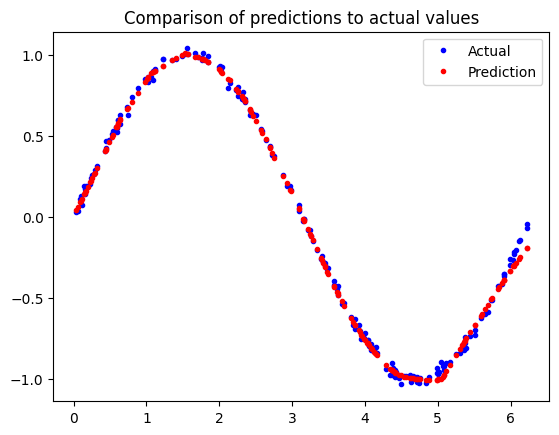

In [35]:
# Plot predictions against actual values
predictions = model.predict(x_test)

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Prediction')
plt.legend()
plt.show()

In [37]:
def representative_data_gen():
    num_samples = 1000  # Número de exemplos representativos a serem gerados
    for _ in range(num_samples):
        # Gere um valor de entrada entre 0 e 2pi
        input_value = np.random.uniform(0, 2 * np.pi)
        # Crie um array numpy com o valor de entrada
        input_array = np.array([input_value], dtype=np.float32)
        # Yield the input array
        yield [input_array]


# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfr80w7fe/assets


INFO:tensorflow:Assets written to: /tmp/tmpfr80w7fe/assets
/home/taffarel55/Repositórios/tcc/5. Modelo tflite com venv/env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-08-27 13:07:02.699807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-27 13:07:02.699850: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-27 13:07:02.700166: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfr80w7fe
2023-08-27 13:07:02.701512: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-27 13:07:02.701567: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfr80w7fe
2023-08-27 13:07:02.70

3624

In [38]:
print(tflite_model)

b' \x00\x00\x00TFL3\x00\x00\x00\x00\x14\x00 \x00\x1c\x00\x18\x00\x14\x00\x10\x00\x0c\x00\x00\x00\x08\x00\x04\x00\x14\x00\x00\x00\x1c\x00\x00\x00\x88\x00\x00\x00\xe0\x00\x00\x00<\x05\x00\x00L\x05\x00\x00\x88\r\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x04\x00\x00\x00n\xfa\xff\xff\x0c\x00\x00\x00\x1c\x00\x00\x008\x00\x00\x00\x0f\x00\x00\x00serving_default\x00\x01\x00\x00\x00\x04\x00\x00\x00\x94\xff\xff\xff\x0c\x00\x00\x00\x04\x00\x00\x00\x07\x00\x00\x00dense_5\x00\x01\x00\x00\x00\x04\x00\x00\x00\x02\xfa\xff\xff\x04\x00\x00\x00\r\x00\x00\x00dense_3_input\x00\x00\x00\x02\x00\x00\x004\x00\x00\x00\x04\x00\x00\x00\xdc\xff\xff\xff\x0f\x00\x00\x00\x04\x00\x00\x00\x13\x00\x00\x00CONVERSION_METADATA\x00\x08\x00\x0c\x00\x08\x00\x04\x00\x08\x00\x00\x00\x0e\x00\x00\x00\x04\x00\x00\x00\x13\x00\x00\x00min_runtime_version\x00\x10\x00\x00\x00X\x04\x00\x00P\x04\x00\x00<\x04\x00\x00\x14\x04\x00\x00\xa4\x03\x00\x00T\x01\x00\x00\xe4\x00\x00\x00\xbc\x00\x00\x00\xb4\x00\x00\x00\xac\x00\x00\x00\xa4\x00\x00\x00\x

In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source

source_text, header_text = convert_bytes_to_c_source(tflite_model,  "sine_model")

with  open('sine_model.h',  'w')  as  file:
    file.write(header_text)

with  open('sine_model.cc',  'w')  as  file:
    file.write(source_text)